In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append('/home/users/jamd1/Isca/')
from isca_tools import cesm
from isca_tools.utils import area_weighting
from isca_tools.utils import print_ds_var_list
import cftime
import matplotlib.units
from matplotlib.dates import ConciseDateConverter
matplotlib.units.registry[cftime.DatetimeNoLeap] = ConciseDateConverter()  # to allow plotting time as x axis
plt.style.use('/home/users/jamd1/Isca/jobs/publish.mplstyle')

In [2]:
ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [3]:
def ds_month_shift(ds, decode_times=True):
    # ds should be loaded with decode_times=False
    # First month is marked as February not January, need to shift every month by -1
    n_day_month = np.asarray([cftime.DatetimeNoLeap(1, i+1, 1).daysinmonth for i in range(12)])         # number of days in each month
    n_months_in_ds = ds.time.size
    n_years_in_ds = int(np.floor(n_months_in_ds/12))
    month_shift_array = np.concatenate((np.tile(n_day_month, n_years_in_ds),
                                        n_day_month[:n_months_in_ds%12]))
    ds_new=ds.assign_coords({'time':('time',ds.time.values-month_shift_array,ds.time.attrs)})
    if decode_times:
        ds_new = xr.decode_cf(ds_new)
    return ds_new

In [4]:
exp_name = 'e.e20.E1850TEST.f09_g17.test'
var_keep = ['TS', 'FSNTOA', 'FLNT', 'gw']
ds = cesm.load_dataset(exp_name, decode_times=False)[var_keep].load()
ds = ds_month_shift(ds)     # Correct for 1st month being Feb not Jan

## Spin up plot
If spin up finished, shoudl get net flux imbalance of 0 in bottom plot. We do not see this.

In [11]:
weight = ds.gw.isel(time=0)
# weight = np.cos(np.deg2rad(ds.lat))
weight = weight / weight.mean()

In [12]:
time_array = ds.time.to_numpy()
temp_global_mean = (weight * ds.TS).mean(dim=['lat', 'lon'])
temp_annual_mean = temp_global_mean.groupby('time.year').mean()

flux_toa_global_mean = (weight * (ds.FSNTOA-ds.FLNT)).mean(dim=['lat', 'lon'])
flux_toa_annual_mean = flux_toa_global_mean.groupby('time.year').mean()

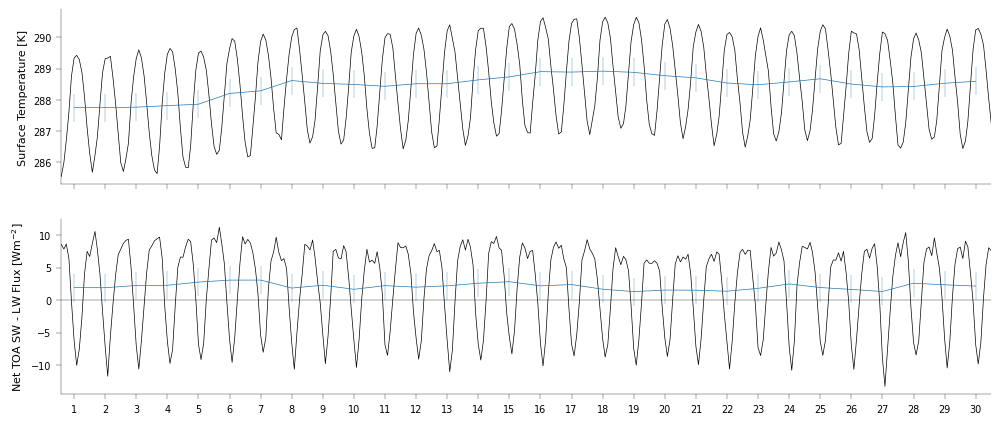

In [13]:
fig, ax = plt.subplots(2,1, figsize=(12, 5), sharex=True)
ax[0].plot(time_array, temp_global_mean, color='k')
ax[0].plot(time_array[5::12], temp_annual_mean, color=default_colors[0], marker='|', markersize=20)
ax[1].plot(time_array, flux_toa_global_mean, color='k')
ax[1].plot(time_array[5::12], flux_toa_annual_mean, color=default_colors[0], marker='|', markersize=20)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_ylabel('Surface Temperature [K]')
ax[1].set_ylabel('Net TOA SW - LW Flux [Wm$^{-2}$]')
ax[0].set_xlim(time_array[0], time_array[-1])
ax[0].set_xticks(time_array[5::12]);
fig.savefig(f"spin_up.pdf", dpi=dpi['combination'], bbox_inches='tight', pad_inches=save_pad_inches)

In [14]:
print(float(flux_toa_annual_mean[-1]))

2.1574137874443027
